In [ ]:
!wget -O news.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1hIVVpBqM6VU4n3ERkKq4tFaH4sKN0Hab"
!unzip news.zip

Archive:  news.zip
  inflating: news.csv                


In [ ]:
!pip install torchtext==0.6.0
!pip install sacremoses==0.0.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Abstactive Summarization

Задача - по тексту сгенерировать выдержку из него.

Например, попробуем по новостям генерировать заголовки:

In [ ]:
!shuf -n 10 news.csv

86920,"Житель города Комсомольск-на-Амуре снял ролик о поездке на трамвае, не имеющем пола. Видеозапись опубликовал YouTube-канал GuberniaTV. Комментируя сюжет, автор видео отметил, что не завидует жителям города, не имеющим личного транспорта и вынужденным пользоваться данным трамваем. Почему в транспортном средстве отсутствует пол, в ролике не поясняется.",Житель Комсомольска-на-Амуре снял на видео поездку на трамвае без пола
399824,"Один человек погиб и еще один пострадал в результате пожара в жилом 12-этажном доме на востоке Москвы, сообщает ""Интерфакс"". Инцидент произошел вечером 4 ноября в доме номер 14, корпус 2 на Просторной улице. Ранее сообщалось, что в подъезде этого дома произошел взрыв, однако эта информация не подтвердилась. Сигнал о возгорании в двухкомнатной квартире на третьем этаже дома поступил на пульт дежурного в 22:05. Прибывшие на место происшествия пожарные спасли одного человека, который выпрыгнул из горящей квартиры. В 23:08 возгорание было ликвидировано. Пл

Токенизируем их. Будем использовать единый словарь для текста и заголовков.

In [ ]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

word_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN, lower=True)
fields = [('source', word_field), ('target', word_field)]

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

data = pd.read_csv('news.csv', delimiter=',')

examples = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    source_text = word_field.preprocess(row.text)
    target_text = word_field.preprocess(row.title)
    examples.append(Example.fromlist([source_text, target_text], fields))

  0%|          | 0/74278 [00:00<?, ?it/s]

Построим датасеты:

In [ ]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

word_field.build_vocab(train_dataset, min_freq=7)
print('Vocab size =', len(word_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 32), shuffle=True, device=DEVICE, sort=False
)

Train size = 63136
Test size = 11142
Vocab size = 55840


## Seq2seq for Abstractive Summarization

Вообще задача не сильно отличается от машинного перевода:

![](https://image.ibb.co/jAf3S0/2018-11-20-9-42-17.png)
*From [Get To The Point: Summarization with Pointer-Generator Networks](https://arxiv.org/pdf/1704.04368.pdf)*

Тут на каждом шаге декодер подглядывает на все токены - точнее, их эмбеддинги после BiRNN.

Возникает вопрос - а зачем вообще RNN, если потом все равно будем смотреть на всё.

# Transformer

Из этой идеи - отказ от RNN - и получился Transformer.

![](https://hsto.org/webt/59/f0/44/59f04410c0e56192990801.png)  
*From Attention is all you need*

Как в случае с RNN мы на каждом шаге применяем одну и ту же операцию (ячейку LSTM) к текущему входу, так и здесь - только теперь связей между timestamp'ами нет и можно обрабатывать их почти параллельно.

*Код дальше очень сильно опирается на шикарную статью [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html).*

## Encoder

Начнем с энкодера:

![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

Он представляет из себя последовательность одинаковых блоков с self-attention + полносвязными слоями.

Можно представить, что это - ячейка LSTM: она тоже применяется к каждому входу с одинаковыми весами. Разница основная в отсутствии рекуррентных связей: за счет этого энкодер может применяться одновременно ко всем входам батча.

### Positional Encoding

Нужно как-то кодировать информацию о том, в каком месте в предложении стоит токен. Авторы предложили делать так:
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$
$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$

где $(pos, i)$ - позиция в предложении и индекс в скрытом векторе размерности до $d_{model}$.

In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

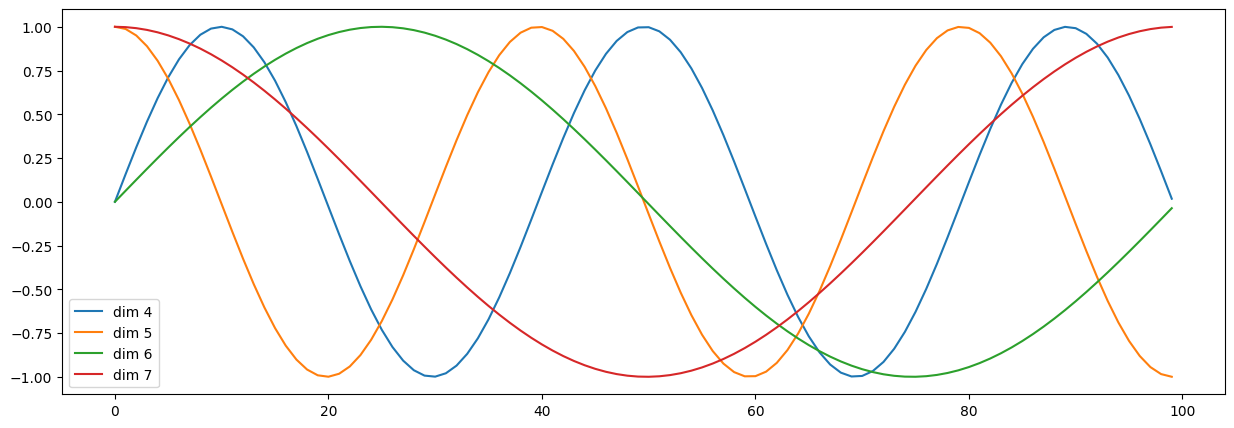

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

В итоге эмбеддинги токена получается как сумма обычного эмбеддинга и эмбеддинга позиции:  
![](http://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

### Residual Connection

Разберем блок энкодера - повторяющейся N раз комбинации операций на первом рисунке.

Самое простое здесь - residual connection. Вместо к выходу произвольной функции $F$ прибавляется её вход
$$y = F(x) \quad \to \quad y = F(x) + x$$

Идея в том, что обычные сети сложно делать слишком глубокими - градиенты затухают. А через этот residual вход $x$ градиентам течь ничего не стоит. В итоге в картинках благодаря таким блокам получилось настакать дофига слоев и улучшить качество (см. ResNet).

Ничего не мешает нам поступить также.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate):
        super().__init__()
        self._norm = LayerNorm(size)
        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, sublayer):
        return inputs + self._dropout(sublayer(self._norm(inputs)))

### Layer Norm

Дополнительно применяется нормализация LayerNorm.

**Batch normalization**  
Мы вообще не разбирали, но BatchNorm работает так:
$$\mu_j = \frac{1}{m}\sum_{i=1}^{m}x_{ij} \\    \sigma_j^2 = \frac{1}{m}\sum_{i=1}^{m}(x_{ij} - \mu_j)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_j}{\sqrt{\sigma_j^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

На каждом батче эти $\mu$ и $\sigma$ пересчитываются, обновляя статистики. На инференсе используются накопленные статистики.

Основной его недостаток - он плохо работает с рекуррентными сетями. Чтобы побороть это придумали:

**Layer normalization**  
А сейчас мы будем пользоваться немного другими формулами:
$$\mu_i = \frac{1}{m}\sum_{j=1}^{m}x_{ij} \\    \sigma_i^2 = \frac{1}{m}\sum_{j=1}^{m}(x_{ij} - \mu_i)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

Разницу с ходу не видно, но она есть:
![](https://image.ibb.co/hjtuX0/layernorm.png)  
*From [Weight Normalization and Layer Normalization Explained ](http://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/)*

Если в BatchNorm статистики считаются для каждой фичи усреднением по батчу, то теперь - для каждого входа усредением по фичам.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()

        self._gamma = nn.Parameter(torch.ones(features))
        self._beta = nn.Parameter(torch.zeros(features))
        self._eps = eps

    def forward(self, inputs):
        mean = inputs.mean(-1, keepdim=True)
        std = inputs.std(-1, keepdim=True)
        return self._gamma * (inputs - mean) / (std + self._eps) + self._beta

### Attention

Весь Transformer опирается на идею self-attention. Выглядит это так:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Эмбеддинг слова *it* строится как комбинация всех эмбеддингов предложения.

В статье придумали делать такой аттеншен:

$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Это примерно как dot-attention на прошлом занятии: запрос (**Q**uery) умножается на ключи (**K**ey) скалярно, затем берется софтмакс - получаются оценки того, насколько интересны разные таймстемпы из значений (**V**alue).

Например, $\mathrm{emb}(\text{it}) = \mathrm{Attention}(\text{it}, \ldots\text{because it was too tired}, \ldots\text{because it was too tired})$.

Только теперь ещё с параметром $\frac{1}{\sqrt{d_k}}$, где $d_k$ - это размерность ключа. Утверждается, это работает лучше при больших размерностях ключа $d_k$.

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, mask):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self._dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

### Multi-Head Attention

![](https://hsto.org/webt/59/f0/44/59f0440f1109b864893781.png)

Важная идея, почему attention (и, главное, self-attention) заработал - использование нескольких голов (multi-head).

Вообще, когда мы делаем attention - мы определяем похожесть ключа и запроса. Многоголовость помогает (должна) определять эту похожесть по разным критериям - синтаксически, семантически и т.д.

Например, на картинке используется две головы и одна голова смотрит на *the animal* при генерации *it*, вторая - на *tired*:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization_2.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Применяется это таким образом:

$$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$
    
где $W^Q_i \in \mathbb{R}^{d_{model} \times d_k}, W_i^K \in \mathbb{R}^{d_{model} \times d_k}, W^V_i \in \mathbb{R}^{d_{model} \times d_v}, W^O \in \mathbb{R}^{hd_v \times d_{model}}$.

В оригинальной статье использовали $h=8$, $d_k=d_v=d_{\text{model}}/h=64$.

Процесс применения такой:
![](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)  
*From Illustrated Transformer*

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads_count, d_model, dropout_rate=0.1):
        super().__init__()

        assert d_model % heads_count == 0

        self._d_k = d_model // heads_count
        self._heads_count = heads_count
        self._attention = ScaledDotProductAttention(dropout_rate)
        self._attn_probs = None

        self._w_q = nn.Linear(d_model, d_model)
        self._w_k = nn.Linear(d_model, d_model)
        self._w_v = nn.Linear(d_model, d_model)
        self._w_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query = self._w_q(query).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        key = self._w_k(key).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        value = self._w_v(value).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        x, self._attn_probs = self._attention(query, key, value, mask)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self._heads_count * self._d_k)
        x = self._w_o(x)
        return x

### Position-wise Feed-Forward Networks

Линейный блок в энкодере выглядит так:
$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        return self.w_2(self.dropout(F.relu(self.w_1(inputs))))

### Encoder block

Соберем все в блок:

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()

        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, d_model),
            PositionalEncoding(d_model, dropout_rate)
        )

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)

        for block in self._blocks:
            inputs = block(inputs, mask)

        return self._norm(inputs)

## Decoder

![](https://hsto.org/webt/59/f0/44/59f0440f7d88f805415140.png)

Блок декодера (серая часть) состоит уже из трех частей:
1. Сперва - тот же self-attention, что и в энкодере
2. Затем - стандартный attention на выходы из энкодера + текущее состояние декодера (такой же был в seq2seq with attention)
3. Наконец - feed-forward блок

Всё это, конечно, с residual связями.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()

        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, d_model),
            PositionalEncoding(d_model, dropout_rate)
        )

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)
        self._out_layer = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
        return self._out_layer(self._norm(inputs))

В декодере нужно аттентиться только на предыдущие токены - сгенерируем маску для этого:

In [ ]:
def subsequent_mask(size):
    mask = torch.ones(size, size, device=DEVICE).triu_()
    return mask.unsqueeze(0) == 0

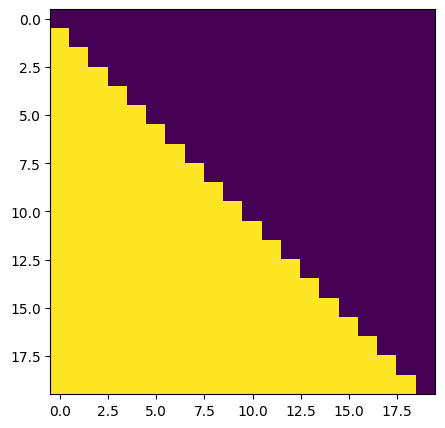

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].cpu().numpy())

## Полная модель

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, source_vocab_size, target_vocab_size, d_model=256, d_ff=1024,
                 blocks_count=4, heads_count=8, dropout_rate=0.1):
        super(EncoderDecoder, self).__init__()

        self.d_model = d_model
        self.encoder = Encoder(source_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        # self.generator = Generator(d_model, target_vocab_size)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)

In [ ]:
def make_mask(source_inputs, target_inputs, pad_idx):
    source_mask = (source_inputs != pad_idx).unsqueeze(-2)
    target_mask = (target_inputs != pad_idx).unsqueeze(-2)
    target_mask = target_mask & subsequent_mask(target_inputs.size(-1)).type_as(target_mask)
    return source_mask, target_mask


def convert_batch(batch, pad_idx=1):
    source_inputs, target_inputs = batch.source.transpose(0, 1), batch.target.transpose(0, 1)
    source_mask, target_mask = make_mask(source_inputs, target_inputs, pad_idx)

    return source_inputs, target_inputs, source_mask, target_mask

In [ ]:
batch = next(iter(train_iter))

In [ ]:
model = EncoderDecoder(source_vocab_size=len(word_field.vocab),
                  target_vocab_size=len(word_field.vocab)).to(DEVICE)

out = model(*convert_batch(batch))

In [ ]:
out.shape, len(word_field.vocab)

(torch.Size([16, 14, 55840]), 55840)

## Оптимизатор

Тоже очень важно в данной модели - использовать правильный оптимизатор

In [ ]:
class NoamOpt(object):
    def __init__(self, model_size, factor=2, warmup=4000, optimizer=None):
        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

Идея в том, чтобы повышать learning rate в течении первых warmup шагов линейно, а затем понижать его по сложной формуле:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

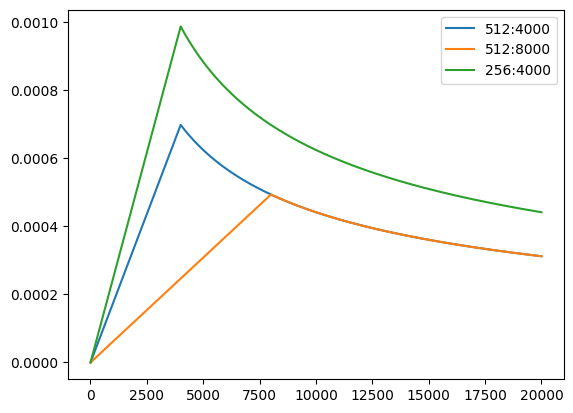

In [ ]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## Тренировка модели

In [ ]:
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0

    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                logits = model.forward(source_inputs, target_inputs[:, :-1], source_mask, target_mask[:, :-1, :-1])

                logits = logits.contiguous().view(-1, logits.shape[-1])
                target = target_inputs[:, 1:].contiguous().view(-1)
                loss = criterion(logits, target)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(),
                                                                                         math.exp(loss.item())))

            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')

        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')

In [ ]:
model = EncoderDecoder(source_vocab_size=len(word_field.vocab), target_vocab_size=len(word_field.vocab)).to(DEVICE)

pad_idx = word_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = NoamOpt(model.d_model)

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

# Домашнее задание

## Применение модели

**Задание** Добавьте генератор суммаризации для модели.

**Задание** Добавьте оценку для модели с помощью ROUGE metric (например, из пакета https://pypi.org/project/pyrouge/0.1.3/)

**Задание** Добавьте визуализацию механизма attention (можно подсмотреть в коде по ссылкам).

## Улучшения модели

**Задание** Попробовать расшарить матрицы эмбеддингов - их тут три (входные в энкодер и декодер + выход декодера).

**Задание** Замените лосс на LabelSmoothing.

**Задание** Добавьте предодученные эмбединги.

# Дополнительные материалы

## Статьи
Attention Is All You Need, 2017 [[pdf]](https://arxiv.org/pdf/1706.03762.pdf)  
Get To The Point: Summarization with Pointer-Generator Networks, 2017 [[pdf]](https://arxiv.org/pdf/1704.04368.pdf)  
Universal Transformers, 2018 [[arxiv]](https://arxiv.org/abs/1807.03819)

## Блоги
[Transformer — новая архитектура нейросетей для работы с последовательностями](https://habr.com/post/341240/)  
[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)  
[The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)  
[Weighted Tranformer](https://einstein.ai/research/blog/weighted-transformer)  
[Your tldr by an ai: a deep reinforced model for abstractive summarization](https://einstein.ai/research/blog/your-tldr-by-an-ai-a-deep-reinforced-model-for-abstractive-summarization)